In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Install Dependencies & Download Training Script
### We need the official train_controlnet.py script from Hugging Face, plus the libraries to run it.

In [2]:
# Install latest compatible versions. We do NOT install xformers.
!pip install -q -U diffusers transformers accelerate peft bitsandbytes

# Download the latest training script
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/controlnet/train_controlnet.py -O train_controlnet.py

print("Environment Ready (Native PyTorch 2.0 Mode).")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 51.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 106.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 34.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB

## Prepare the Data
### Find where Kaggle has mounted the folder

In [3]:
import os

# Search for the dataset directory in /kaggle/input
INPUT_ROOT = "/kaggle/input"
DATASET_DIR = None

for root, dirs, files in os.walk(INPUT_ROOT):
    if "train" in dirs and "validation" in dirs:
        DATASET_DIR = root
        break

if DATASET_DIR:
    print(f"SUCCESS: Dataset found at: {DATASET_DIR}")
    print("Structure check:")
    print(f" - Train: {os.path.join(DATASET_DIR, 'train')}")
    print(f" - Validation: {os.path.join(DATASET_DIR, 'validation')}")
else:
    print("ERROR: Could not find the 'train' and 'validation' folders. Please check your input.")

SUCCESS: Dataset found at: /kaggle/input/flir-controlnet-complete
Structure check:
 - Train: /kaggle/input/flir-controlnet-complete/train
 - Validation: /kaggle/input/flir-controlnet-complete/validation


## Select a Validation Image
### The training script allows us to monitor progress by generating an image every few steps. We will pick one specific Thermal image from your validation set to track how the model improves.

In [21]:
import glob

# Look for validation images in the path we found above
val_cond_images = glob.glob(f"{DATASET_DIR}/validation/conditioning_images/FLIR_08863.png")

if val_cond_images:
    VAL_IMAGE_PATH = val_cond_images
    print(f"Validation Image Selected: {VAL_IMAGE_PATH}")
    
    # Generic prompt for tracking
    VAL_PROMPT = "a street scene with a stop sign and a person crossing the street"
else:
    print("Error: No validation images found. Check if the path in Cell 2 is correct.")

Validation Image Selected: ['/kaggle/input/flir-controlnet-complete/validation/conditioning_images/FLIR_08863.png']


## Create "Absolute Path" Metadata 

### Run this cell. It reads your current metadata and creates a new version where every file path is fully resolved (e.g., /kaggle/input/flir-controlnet-complete/...).

In [9]:
import json
import os
from pathlib import Path

# Configuration
INPUT_BASE = "/kaggle/input/flir-controlnet-complete"
OUTPUT_BASE = "/kaggle/working/resolved_data"

def create_absolute_metadata(split_name):
    input_dir = os.path.join(INPUT_BASE, split_name)
    metadata_path = os.path.join(input_dir, "metadata.jsonl")
    
    if not os.path.exists(metadata_path):
        print(f"Skipping {split_name} (no metadata found)")
        return

    print(f"Resolving paths for {split_name}...")
    new_lines = []
    
    with open(metadata_path, 'r') as f:
        for line in f:
            item = json.loads(line)
            
            # Convert relative paths to absolute paths
            # The original metadata has "images/file.png"
            # We prepend the full input directory path
            
            # Handle target image
            if "file_name" in item:
                item["image"] = os.path.join(input_dir, item.pop("file_name"))
            elif "image" in item:
                item["image"] = os.path.join(input_dir, item["image"])
                
            # Handle conditioning image
            if "conditioning_image" in item:
                item["conditioning_image"] = os.path.join(input_dir, item["conditioning_image"])
            
            new_lines.append(item)

    # Save to working directory
    os.makedirs(OUTPUT_BASE, exist_ok=True)
    with open(os.path.join(OUTPUT_BASE, f"{split_name}.jsonl"), 'w') as f:
        for item in new_lines:
            f.write(json.dumps(item) + "\n")
            
    print(f"Saved {len(new_lines)} items to {OUTPUT_BASE}/{split_name}.jsonl")

# Run for both splits
create_absolute_metadata("train")
create_absolute_metadata("validation")

Resolving paths for train...
Saved 2000 items to /kaggle/working/resolved_data/train.jsonl
Resolving paths for validation...
Saved 1257 items to /kaggle/working/resolved_data/validation.jsonl


## Apply the "Magic Patch" 

### Run this code in a new cell. It opens train_controlnet.py, finds the spot where the data is loaded, and injects a line to explicitly convert your columns into Images.

In [12]:
# Read the current script
with open("train_controlnet.py", "r") as f:
    code = f.read()

# 1. Add necessary imports to the top
if "from PIL import Image as PILImage" not in code:
    code = "from PIL import Image as PILImage\n" + code

# 2. Define the robust loading function
# We inject this helper function right before the main() function
helper_function = '''
def robust_load_image(img_input):
    """Helper to handle both PIL Images and String Paths"""
    if isinstance(img_input, str):
        try:
            return PILImage.open(img_input).convert("RGB")
        except Exception as e:
            print(f"Error opening image path: {img_input} - {e}")
            # Return a black image to prevent crashing
            return PILImage.new("RGB", (512, 512))
    return img_input.convert("RGB")
'''

if "def robust_load_image" not in code:
    code = code.replace("def main(args):", helper_function + "\n\ndef main(args):")

# 3. Replace the breaking lines in the training loop
# We replace the simple list comprehension with our robust loader
old_line_1 = 'images = [image.convert("RGB") for image in examples[image_column]]'
new_line_1 = 'images = [robust_load_image(image) for image in examples[image_column]]'

old_line_2 = 'conditioning_images = [image.convert("RGB") for image in examples[conditioning_image_column]]'
new_line_2 = 'conditioning_images = [robust_load_image(image) for image in examples[conditioning_image_column]]'

code = code.replace(old_line_1, new_line_1)
code = code.replace(old_line_2, new_line_2)

# 4. Save the patched script
with open("train_controlnet.py", "w") as f:
    f.write(code)

print("SUCCESS: train_controlnet.py has been patched with robust image loading logic.")

SUCCESS: train_controlnet.py has been patched with robust image loading logic.


## The Training Command (The Core Requirement)
### This runs the training.

    Base Model: stable-diffusion-v1-5/stable-diffusion-v1-5 (Standard SD 1.5).

    Optimization: Uses fp16 (mixed precision) and gradient_accumulation to fit on the T4 GPU.

    Hyperparameters: 

        Resolution: 512

        Batch Size: 4

        Learning Rate: 1e−5

        Max Steps: 5000 (Enough to see results, usually takes ~2 hours).

In [15]:
import subprocess
import glob

# Same configuration as before
cmd = [
    "accelerate", "launch",
    "--mixed_precision=fp16",
    "--num_processes=2",
    "train_controlnet.py",
    "--pretrained_model_name_or_path=stable-diffusion-v1-5/stable-diffusion-v1-5",
    "--output_dir=/kaggle/working/model_output",
    "--dataset_name=json",
    "--train_data_dir=/kaggle/working/resolved_data",
    "--image_column=image",
    "--caption_column=text",
    "--conditioning_image_column=conditioning_image",
    "--resolution=512",
    "--learning_rate=1e-5",
    # Just grab any valid validation image to keep it happy
    f"--validation_image={glob.glob('/kaggle/input/flir-controlnet-complete/validation/conditioning_images/*.png')[0]}",
    "--validation_prompt=thermal image of a street scene",
    "--train_batch_size=4",
    "--gradient_accumulation_steps=4",
    "--mixed_precision=fp16",
    "--use_8bit_adam",
    "--set_grads_to_none",   
    "--checkpointing_steps=500",
    "--validation_steps=500",
    "--max_train_steps=1000"
]

print("Starting Training (Nuclear Patch Applied)...")
subprocess.run(cmd)

Starting Training (Nuclear Patch Applied)...


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

CompletedProcess(args=['accelerate', 'launch', '--mixed_precision=fp16', '--num_processes=2', 'train_controlnet.py', '--pretrained_model_name_or_path=stable-diffusion-v1-5/stable-diffusion-v1-5', '--output_dir=/kaggle/working/model_output', '--dataset_name=json', '--train_data_dir=/kaggle/working/resolved_data', '--image_column=image', '--caption_column=text', '--conditioning_image_column=conditioning_image', '--resolution=512', '--learning_rate=1e-5', '--validation_image=/kaggle/input/flir-controlnet-complete/validation/conditioning_images/FLIR_09555.png', '--validation_prompt=thermal image of a street scene', '--train_batch_size=4', '--gradient_accumulation_steps=4', '--mixed_precision=fp16', '--use_8bit_adam', '--set_grads_to_none', '--checkpointing_steps=500', '--validation_steps=500', '--max_train_steps=1000'], returncode=0)

In [16]:
import shutil
import os
from IPython.display import FileLink

# Define the folder you want to save (the latest checkpoint)
# Change 'checkpoint-1000' if you trained for longer
CHECKPOINT_FOLDER = "/kaggle/working/model_output/checkpoint-1000"
OUTPUT_ZIP = "/kaggle/working/my_controlnet_checkpoint.zip"

if os.path.exists(CHECKPOINT_FOLDER):
    print(f"Zipping {CHECKPOINT_FOLDER}...")
    shutil.make_archive("/kaggle/working/my_controlnet_checkpoint", 'zip', CHECKPOINT_FOLDER)
    print("Done! Download the link below:")
    display(FileLink(r'my_controlnet_checkpoint.zip'))
else:
    print("Checkpoint folder not found! Did training finish?")

Zipping /kaggle/working/model_output/checkpoint-1000...
Done! Download the link below:


/kaggle/working/my_controlnet_checkpoint.zip

Loading ControlNet from /kaggle/working/model_output/checkpoint-1000/controlnet...
Loading Stable Diffusion Pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Running inference on 5 validation images...
[1/5] Generating: 'a street scene with a stop sign and a person cross...'


  0%|          | 0/20 [00:00<?, ?it/s]

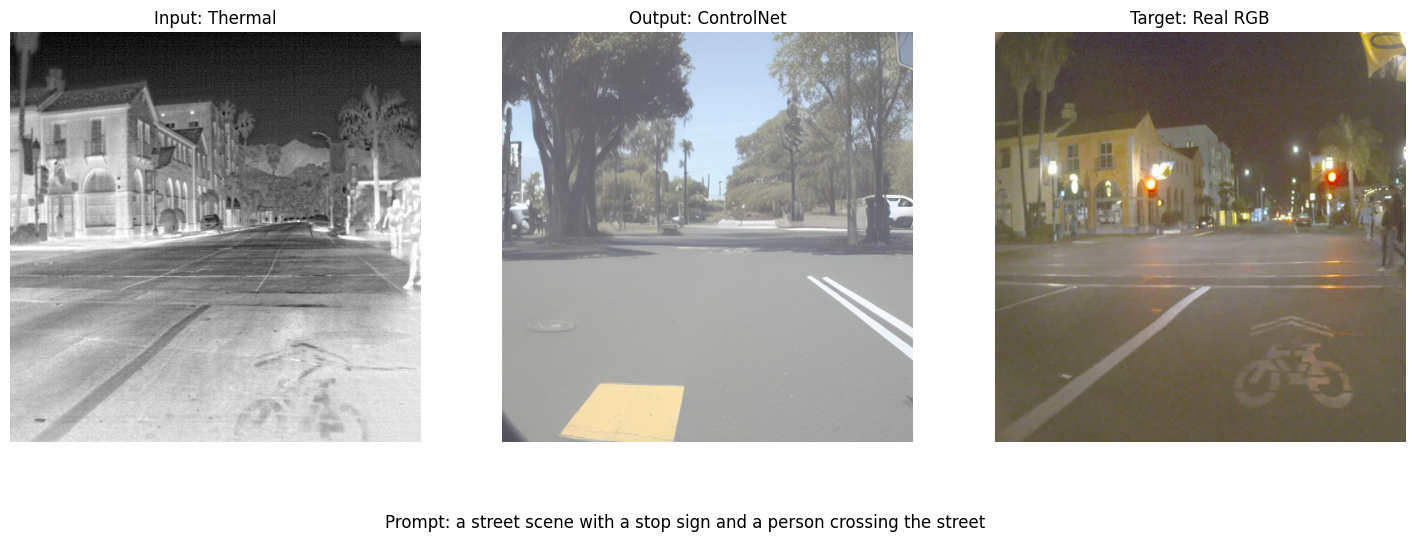

[2/5] Generating: 'a person riding a bike on a city street...'


  0%|          | 0/20 [00:00<?, ?it/s]

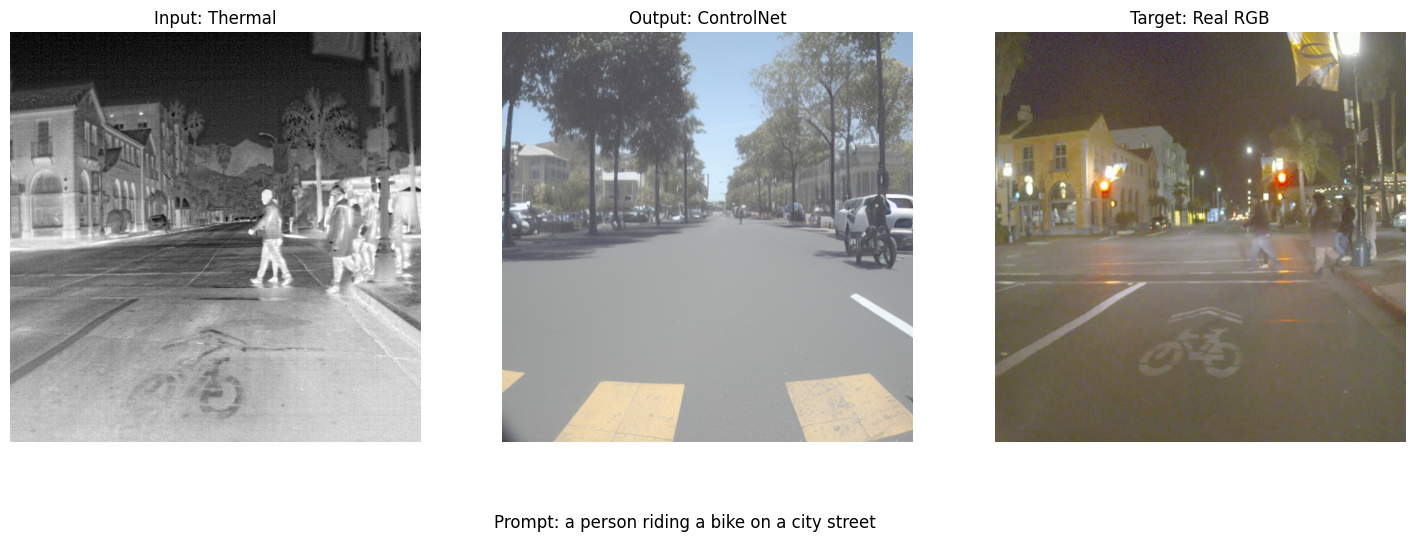

[3/5] Generating: 'a person is walking across a crosswalk...'


  0%|          | 0/20 [00:00<?, ?it/s]

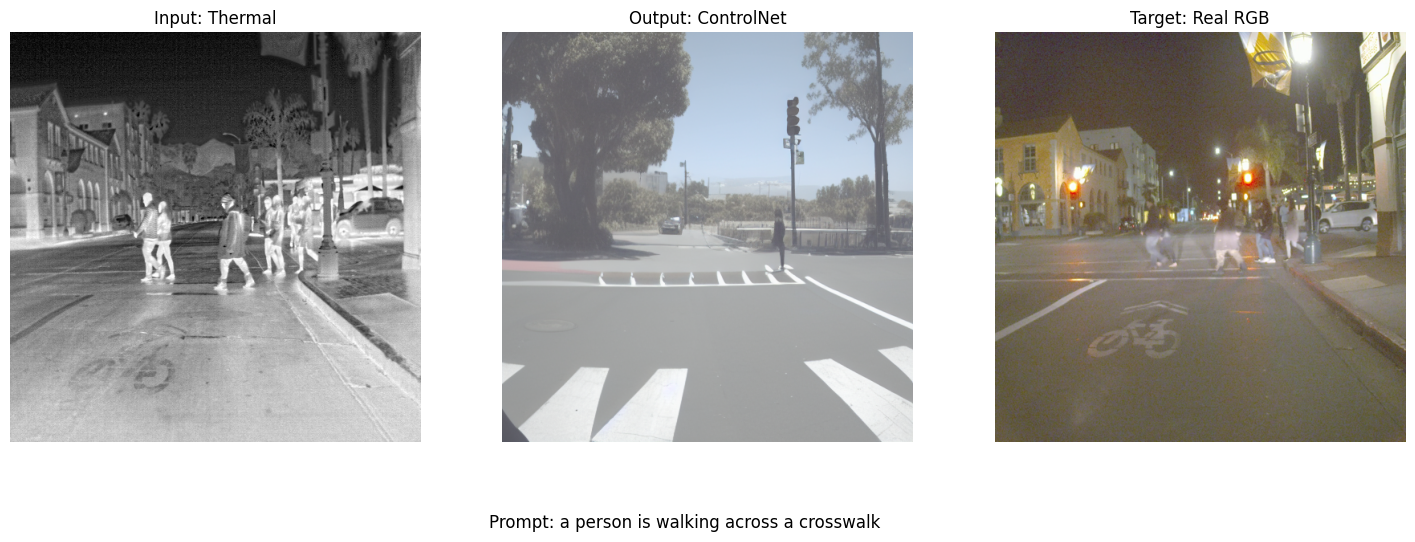

[4/5] Generating: 'a person is crossing the street at night...'


  0%|          | 0/20 [00:00<?, ?it/s]

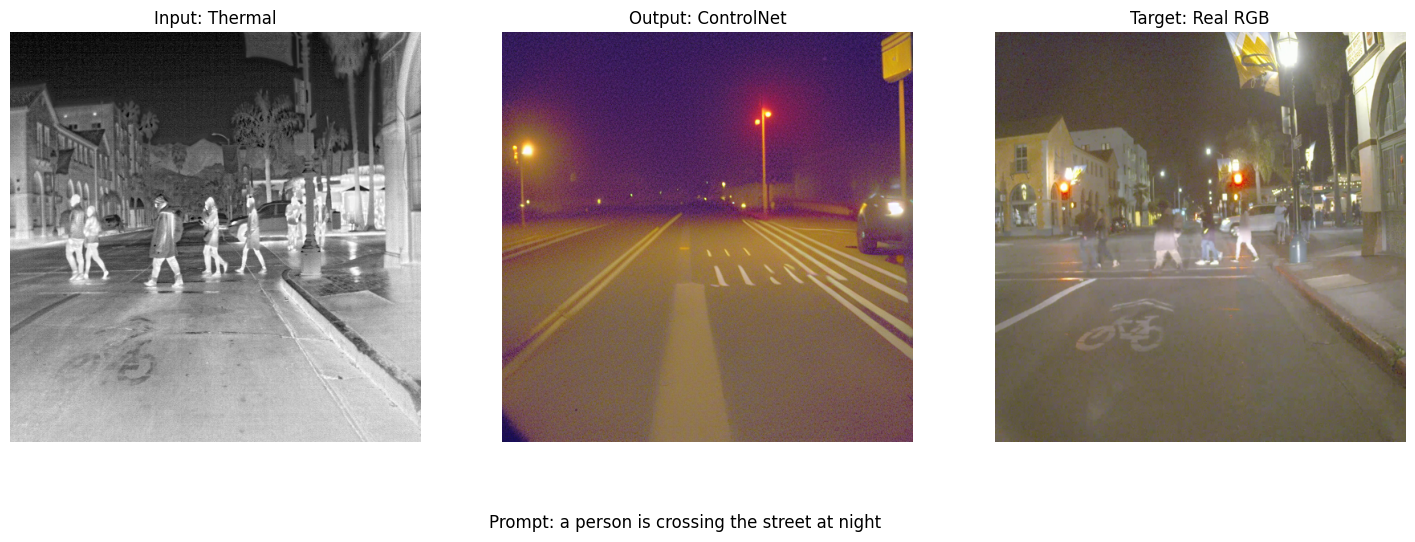

[5/5] Generating: 'a group of people crossing a street at night...'


  0%|          | 0/20 [00:00<?, ?it/s]

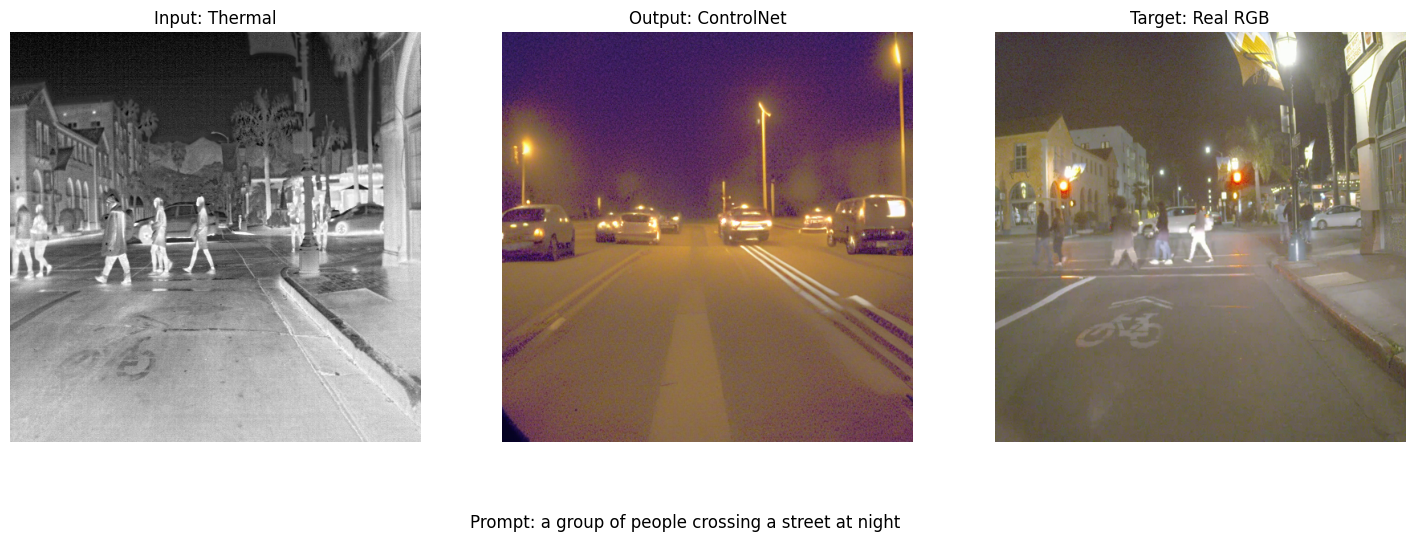

In [18]:
import torch
import json
import os
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# ================= CONFIGURATION =================
CHECKPOINT_PATH = "/kaggle/working/model_output/checkpoint-1000/controlnet"
BASE_MODEL = "stable-diffusion-v1-5/stable-diffusion-v1-5"
VAL_METADATA = "/kaggle/working/resolved_data/validation.jsonl"
NUM_SAMPLES = 5
# =================================================

def load_validation_samples(limit=5):
    """Reads the first N entries from the validation metadata file."""
    samples = []
    # Verify file exists
    if not os.path.exists(VAL_METADATA):
        print(f"Error: Metadata file not found at {VAL_METADATA}")
        return []
        
    with open(VAL_METADATA, 'r') as f:
        for i, line in enumerate(f):
            if i >= limit: break
            entry = json.loads(line)
            samples.append(entry)
    return samples

def run_inference():
    # 1. Load the Trained ControlNet
    print(f"Loading ControlNet from {CHECKPOINT_PATH}...")
    try:
        controlnet = ControlNetModel.from_pretrained(
            CHECKPOINT_PATH,
            torch_dtype=torch.float16
        )
    except OSError:
        print("⚠️ Explicit 'controlnet' subfolder not found. Trying parent folder...")
        controlnet = ControlNetModel.from_pretrained(
            "/kaggle/working/model_output/checkpoint-1000",
            torch_dtype=torch.float16
        )

    # 2. Load the Stable Diffusion Pipeline
    print("Loading Stable Diffusion Pipeline...")
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        BASE_MODEL,
        controlnet=controlnet,
        torch_dtype=torch.float16,
        safety_checker=None 
    )

    # 3. Optimize for T4 GPU (CRITICAL FIX HERE)
    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
    pipe.enable_model_cpu_offload()
    
    # --- FIX: REMOVE xformers, use standard attention slicing ---
    # This works on all machines without needing the extra library
    pipe.enable_attention_slicing() 
    # ------------------------------------------------------------

    # 4. Get Samples
    samples = load_validation_samples(NUM_SAMPLES)
    if not samples:
        print("No samples found. Check paths.")
        return

    print(f"Running inference on {len(samples)} validation images...")

    # 5. Inference Loop
    for idx, item in enumerate(samples):
        try:
            cond_path = item['conditioning_image']
            target_path = item['image']
            prompt = item['text']

            # Robust loading (handle if paths are still relative or absolute)
            if not os.path.exists(cond_path):
                # Try finding it in the input directory if absolute path fails
                filename = os.path.basename(cond_path)
                cond_path = f"/kaggle/input/flir-controlnet-complete/validation/conditioning_images/{filename}"
                
            if not os.path.exists(target_path):
                filename = os.path.basename(target_path)
                target_path = f"/kaggle/input/flir-controlnet-complete/validation/images/{filename}"

            thermal_image = Image.open(cond_path).convert("RGB")
            ground_truth = Image.open(target_path).convert("RGB")

            print(f"[{idx+1}/{NUM_SAMPLES}] Generating: '{prompt[:50]}...'")

            # GENERATE
            generator = torch.manual_seed(42)
            generated_image = pipe(
                prompt,
                image=thermal_image,
                num_inference_steps=20,
                generator=generator,
                controlnet_conditioning_scale=1.0 
            ).images[0]

            # 6. Display Results
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))

            axs[0].imshow(thermal_image)
            axs[0].set_title("Input: Thermal")
            axs[0].axis("off")

            axs[1].imshow(generated_image)
            axs[1].set_title("Output: ControlNet")
            axs[1].axis("off")

            axs[2].imshow(ground_truth)
            axs[2].set_title("Target: Real RGB")
            axs[2].axis("off")

            plt.figtext(0.5, 0.01, f"Prompt: {prompt}", ha="center", fontsize=12, wrap=True)
            plt.show()
            
        except Exception as e:
            print(f"Skipping sample {idx}: {e}")

# Run it
run_inference()

Checking data from: /kaggle/working/resolved_data/train.jsonl
Displaying 4 training pairs...


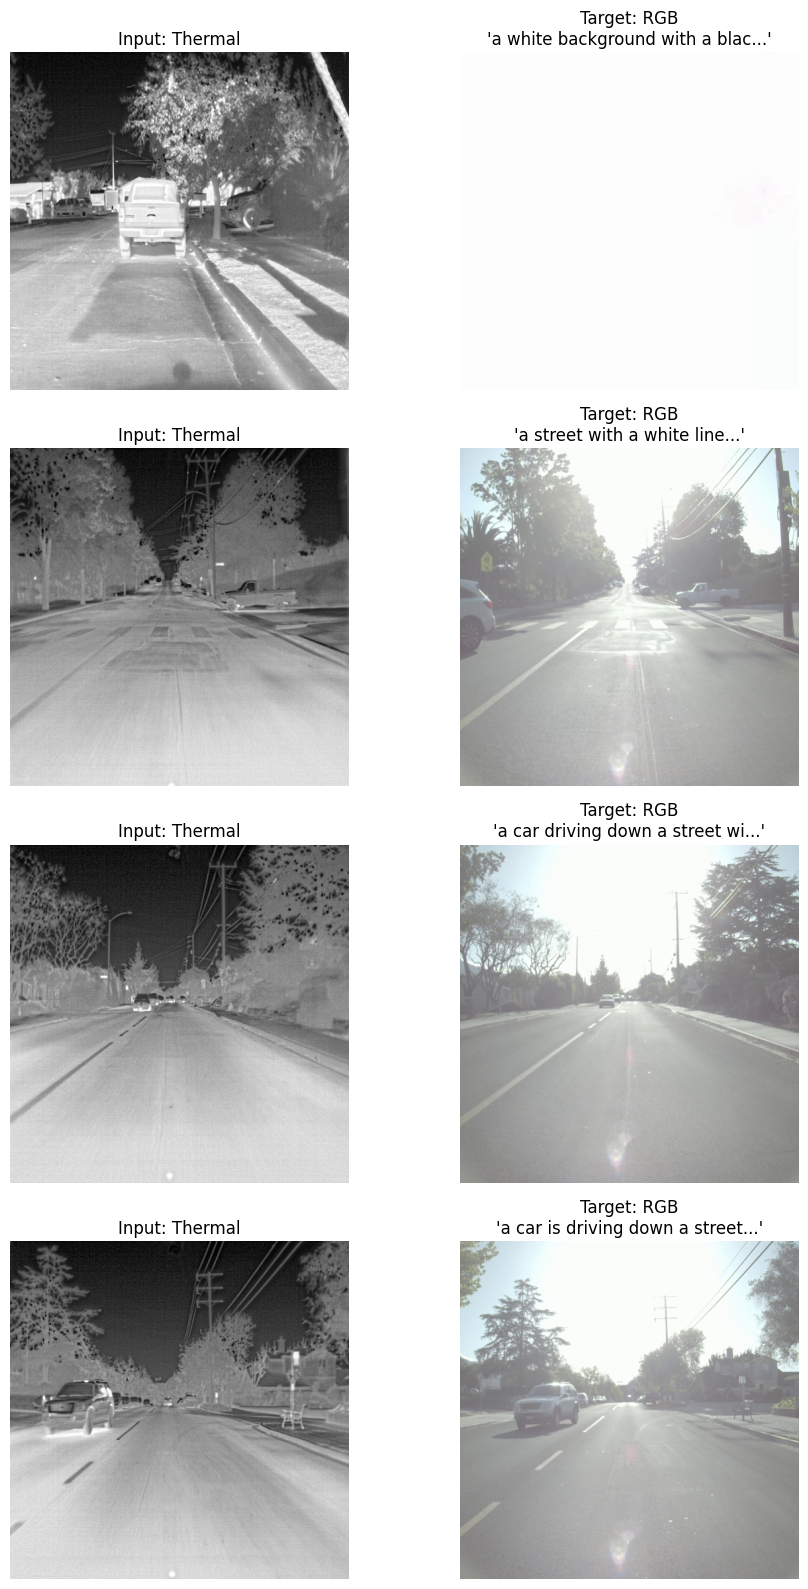

In [19]:
import json
import os
import matplotlib.pyplot as plt
from PIL import Image

# Configuration
TRAIN_METADATA = "/kaggle/working/resolved_data/train.jsonl"
NUM_SAMPLES = 4

def check_data_loading():
    print(f"Checking data from: {TRAIN_METADATA}")
    
    if not os.path.exists(TRAIN_METADATA):
        print("❌ Error: Metadata file not found!")
        return

    samples = []
    with open(TRAIN_METADATA, 'r') as f:
        for i, line in enumerate(f):
            if i >= NUM_SAMPLES: break
            samples.append(json.loads(line))

    # Visualize
    fig, axs = plt.subplots(NUM_SAMPLES, 2, figsize=(10, 4 * NUM_SAMPLES))
    
    print(f"Displaying {NUM_SAMPLES} training pairs...")
    
    for i, item in enumerate(samples):
        # 1. Get Paths
        cond_path = item['conditioning_image']
        target_path = item['image'] # Or 'file_name' if you didn't rename it
        caption = item['text']
        
        # 2. Try Loading Images (Simulating the Robust Loader)
        try:
            # Check if file exists first
            if not os.path.exists(cond_path):
                print(f"❌ Missing File: {cond_path}")
                continue
                
            img_cond = Image.open(cond_path).convert("RGB")
            img_target = Image.open(target_path).convert("RGB")
            
            # 3. Plot
            # Thermal (Left)
            axs[i, 0].imshow(img_cond)
            axs[i, 0].set_title("Input: Thermal")
            axs[i, 0].axis('off')
            
            # Target (Right)
            axs[i, 1].imshow(img_target)
            axs[i, 1].set_title(f"Target: RGB\n'{caption[:30]}...'")
            axs[i, 1].axis('off')
            
        except Exception as e:
            print(f"❌ Error loading sample {i}: {e}")

    plt.tight_layout()
    plt.show()

check_data_loading()

In [ ]:
import subprocess
import glob

# 1. Define Paths
# We point to the checkpoint you just created
RESUME_PATH = "/kaggle/working/model_output/checkpoint-1000"
DATASET_DIR = "/kaggle/working/resolved_data"
OUTPUT_DIR = "/kaggle/working/model_output"

# 2. Validation Config
val_cond_images = glob.glob("/kaggle/input/flir-controlnet-complete/validation/conditioning_images/*.png")
VAL_IMAGE_PATH = val_cond_images[0] if val_cond_images else ""

# 3. The Resume Command
cmd = [
    "accelerate", "launch",
    "--mixed_precision=fp16",
    "--num_processes=2",
    "train_controlnet.py",
    "--pretrained_model_name_or_path=stable-diffusion-v1-5/stable-diffusion-v1-5",
    f"--output_dir={OUTPUT_DIR}",
    "--dataset_name=json",
    f"--train_data_dir={DATASET_DIR}",
    "--image_column=image",
    "--caption_column=text",
    "--conditioning_image_column=conditioning_image",
    "--resolution=512",
    "--learning_rate=1e-5",
    f"--validations_image={VAL_IMAGE_PATH}",
    "--validation_prompt=thermal image of a street scene",
    "--train_batch_size=4",
    "--gradient_accumulation_steps=4",
    "--mixed_precision=fp16",
    "--use_8bit_adam",
    "--set_grads_to_none",
    "--checkpointing_steps=1000",
    "--validation_steps=1000",
    
    # --- CRITICAL CHANGES ---
    f"--resume_from_checkpoint={RESUME_PATH}", # Resume from step 1000
    "--max_train_steps=5000"                    # Train until step 5000
    # ------------------------
]

print("Resuming Training from Step 1000...")
subprocess.run(cmd)

Resuming Training from Step 1000...


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Resuming from checkpoint checkpoint-1000


All model checkpoint weights were used when initializing ControlNetModel.

All the weights of ControlNetModel were initialized from the model checkpoint at /kaggle/working/model_output/checkpoint-1000.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ControlNetModel for predictions without further training.
Steps:  40%|████      | 2000/5000 [1:51:21<5:37:52,  6.76s/it, loss=0.0826, lr=1e-5]Configuration saved in /kaggle/working/model_output/checkpoint-2000/controlnet/config.json
Model weights saved in /kaggle/working/model_output/checkpoint-2000/controlnet/diffusion_pytorch_model.safetensors
{'controlnet', 'requires_safety_checker', 'image_encoder'} was not found in config. Values will be initialized to default values.

Loading pipeline components...:  50%|█████     | 3/6 [00:00<00:00, 10.46it/s]Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stable-diffusion-v1-5/stable-diffusion-v1-5.
{'prediction